# Protein Secondary Structure Prediction (ESM2 Embeddings)

This notebook trains a BiLSTM-based model (Model 5) for Q3 and Q8 prediction.

Instead of an `nn.Embedding` layer, this approach uses pre-computed **protein language model (PLM) embeddings** generated by the `esm2_t12_35M_UR50D` model from Hugging Face. The workflow is:
1.  **Prep Data**: Load and split the raw text sequences (Q3 & Q8).
2.  **Generate Embeddings**: Feed the text sequences into the ESM2 model to get high-dimensional vector representations (`[L, 480]`) for each protein.
3.  **Create DataLoaders**: Build `DataLoaders` that batch these pre-computed embeddings.
4.  **Train Model**: Train a *new* BiLSTM-based model (`ESMProteinStructurePredictor`) that takes these embeddings as input.
5.  **Evaluate**: Evaluate the model on Q3, then repeat the process for Q8.

In [ ]:

import os
import random
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.amp import autocast, GradScaler

SEED = 1337
os.environ["PYTHONHASHSEED"] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


# Reproducibility flags
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Optional (stricter, may slow down & restrict some ops):
# torch.use_deterministic_algorithms(True)
NUM_WORKERS = 0 
# Pin memory for faster CPU-to-GPU data transfer
PIN_MEMORY = torch.cuda.is_available() 

# Reproducibility helpers for DataLoaders
def _worker_init_fn(worker_id):
    """Set seed for dataloader workers."""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed + worker_id)
    random.seed(worker_seed + worker_id)

g = torch.Generator()
g.manual_seed(SEED)


## Configuration and Data Loading

We define global constants, load the `.csv` file, and filter out any sequences containing the non-standard amino acid character (`*`).

In [ ]:

DATA_FILE = '2018-06-06-pdb-intersect-pisces.csv'
BATCH_SIZE = 32 # Recommended standard batch size
TEST_SIZE = 0.15 
VAL_SIZE = 0.15  

# Load the dataset
try:
    df = pd.read_csv(DATA_FILE)
except FileNotFoundError:
    print(f"Error: The file '{DATA_FILE}' was not found. Please ensure it is in the working directory.")
    exit()

# Apply the fix for the SyntaxWarning using a raw string r'\*'
# Filter out sequences that contain the nonstandard amino acid mask ('*')
df_filtered = df[~df['seq'].str.contains(r'\*')].copy()

# Focus on core columns
df_filtered = df_filtered[['seq', 'sst3', 'sst8', 'len']]
print(f"Initial sequences: {len(df)}. Sequences after filtering: {len(df_filtered)}")

Initial sequences: 9078. Sequences after filtering: 8994


## Define Mappings and Tokenization

This block is for data tokenization. We create dictionaries to map each character to a unique integer:
* **`aa_to_int`**: For the 20 standard amino acids (input features), plus a `PAD` token (index 0).
* **`q3_to_int`**: For the 3-class secondary structure labels (H, E, C), plus a `PAD` token (index 3).
* **`q8_to_int`**: For the 8-class labels (0-7), using **-100** as the `PAD` token. This is the standard practice for PyTorch's `CrossEntropyLoss` `ignore_index`.

These mappings are then applied to the dataframe to create new integer-encoded sequence columns.

In [ ]:

AA_ALPHABET = list("ACDEFGHIKLMNPQRSTVWY")
Q3_ALPHABET = list("HEC") 
Q8_ALPHABET = list("HECBITGS") 

# Amino Acid (Input) Mappings
aa_to_int = {aa: i + 1 for i, aa in enumerate(AA_ALPHABET)}
aa_to_int['PAD'] = 0
AA_VOCAB_SIZE = len(aa_to_int)

# Q3 Label Mappings: Classes 0, 1, 2 and PAD 3
# H -> 0, E -> 1, C -> 2 (Standard PyTorch classification indices)
q3_to_int = {ss: i for i, ss in enumerate(Q3_ALPHABET)} 
q3_to_int['PAD'] = 3 # PAD index is moved to 3
Q3_NUM_CLASSES = len(Q3_ALPHABET) # 3
Q3_PAD_INDEX = q3_to_int['PAD'] # 3


# Classes will be 0-7
q8_to_int = {ss: i for i, ss in enumerate(Q8_ALPHABET)} 
# Use -100 for padding, as it's outside the 0-7 class range
q8_to_int['PAD'] = -100 
Q8_NUM_CLASSES = len(Q8_ALPHABET) # 8
Q8_PAD_INDEX = q8_to_int['PAD'] # -100

print(f"Q8 Mappings: {q8_to_int}")
print(f"Q8 Num Classes: {Q8_NUM_CLASSES}")
print(f"Q8 Pad Index: {Q8_PAD_INDEX}")


# Apply tokenization to input (seq) and both labels (sst3, sst8)
df_filtered['seq_int'] = df_filtered['seq'].apply(
    lambda x: [aa_to_int.get(char, aa_to_int['PAD']) for char in x]
)
df_filtered['sst3_int'] = df_filtered['sst3'].apply(
    lambda x: [q3_to_int.get(char, q3_to_int['PAD']) for char in x]
)
df_filtered['sst8_int'] = df_filtered['sst8'].apply(
    lambda x: [q8_to_int.get(char, q8_to_int['PAD']) for char in x]
)

MAX_LEN = df_filtered['len'].max()
print(f"Max Sequence Length (MAX_LEN): {MAX_LEN}")

Q8 Mappings: {'H': 0, 'E': 1, 'C': 2, 'B': 3, 'I': 4, 'T': 5, 'G': 6, 'S': 7, 'PAD': -100}
Q8 Num Classes: 8
Q8 Pad Index: -100
Max Sequence Length (MAX_LEN): 1632


## Padding Sequences (for Labels)

This function pads the **label** sequences (`Y_Q3`, `Y_Q8`) to the maximum length in the dataset. The feature sequences (`X`) are also padded, but they will **not** be used as model input. We only use them to get the text sequences for ESM.

In [20]:
def apply_padding(sequences, max_len, padding_value):
    """Pads integer sequences to a fixed length using post-padding (PyTorch convention)."""
    padded_sequences = []
    for seq in sequences:
        # Calculate how much padding is needed
        pad_amount = max_len - len(seq)
        if pad_amount > 0:
            # Post-pad: sequence + [padding_value, padding_value, ...]
            padded_seq = seq + [padding_value] * pad_amount
        else:
            # Truncate if sequence is longer than MAX_LEN
            padded_seq = seq[:max_len]
        padded_sequences.append(padded_seq)
    
    # Convert list of lists to a NumPy array
    return np.array(padded_sequences, dtype=np.int64) 

# Pad and convert to NumPy arrays (PyTorch requires long/int64 for indices)
X = apply_padding(df_filtered['seq_int'].tolist(), MAX_LEN, aa_to_int['PAD'])
Y_Q3 = apply_padding(df_filtered['sst3_int'].tolist(), MAX_LEN, q3_to_int['PAD'])
Y_Q8 = apply_padding(df_filtered['sst8_int'].tolist(), MAX_LEN, q8_to_int['PAD'])
print(f"Padded Features (X) shape: {X.shape}")

Padded Features (X) shape: (8994, 1632)


## Train-Validation-Test Split (Labels & Indices)

Here, we split the padded label tensors (`Y_Q3_t`, `Y_Q8_t`) into training, validation, and test sets. We also perform an identical split on the *indices* of `df_filtered` to get the corresponding raw text sequences for each set.

In [21]:
# --- 4. Train-Validation-Test Split and PyTorch Tensor Conversion ---
val_ratio_temp = VAL_SIZE / (1 - TEST_SIZE)

# Split 1: Get Test Set
X_temp, X_test, Y_Q3_temp, Y_Q3_test, Y_Q8_temp, Y_Q8_test = train_test_split(
    X, Y_Q3, Y_Q8, test_size=TEST_SIZE, random_state=42
)

# Split 2: Get Train and Validation Sets
X_train, X_val, Y_Q3_train, Y_Q3_val, Y_Q8_train, Y_Q8_val = train_test_split(
    X_temp, Y_Q3_temp, Y_Q8_temp, test_size=val_ratio_temp, random_state=42
)

# Convert all NumPy arrays to PyTorch Tensors
X_train_t = torch.from_numpy(X_train).long()
X_val_t = torch.from_numpy(X_val).long()
X_test_t = torch.from_numpy(X_test).long()

Y_Q3_train_t = torch.from_numpy(Y_Q3_train).long()
Y_Q3_val_t = torch.from_numpy(Y_Q3_val).long()
Y_Q3_test_t = torch.from_numpy(Y_Q3_test).long()

Y_Q8_train_t = torch.from_numpy(Y_Q8_train).long()
Y_Q8_val_t = torch.from_numpy(Y_Q8_val).long()
Y_Q8_test_t = torch.from_numpy(Y_Q8_test).long()

print(f"\nTraining set size: {len(X_train_t)} | Validation set size: {len(X_val_t)} | Test set size: {len(X_test_t)}")




Training set size: 6295 | Validation set size: 1349 | Test set size: 1350


## Generate ESM2 Embeddings

This is the core of the new approach.
1.  **Load ESM2 Model**: Loads the `facebook/esm2_t12_35M_UR50D` model and tokenizer from Hugging Face.
2.  **Define `embed_with_esm_to_list`**: This function takes a list of raw protein sequences (e.g., `["ACDE..."]`), tokenizes them, passes them through the ESM2 model in batches, and extracts the final hidden state (the embeddings).
3.  **Generate & Save Embeddings**: It runs this function for the `train_seqs`, `val_seqs`, and `test_seqs`.
4.  **Result**: The output is `X_train_esm_list`, `X_val_esm_list`, and `X_test_esm_list`, which are Python lists of tensors (e.g., `[torch.Size([L1, 480]), torch.Size([L2, 480]), ...]`). These are kept on the CPU in `float16` to save memory.

In [ ]:

from transformers import AutoTokenizer, AutoModel, AutoConfig
import logging
from tqdm.auto import tqdm

MAX_TRAIN_LEN = None

# Suppress HuggingFace warnings
logging.getLogger("transformers").setLevel(logging.ERROR)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ESM_MODEL_NAME = "facebook/esm2_t12_35M_UR50D"  # 35M params, 480-D embeddings

print(f"Using device: {DEVICE}")
print(f"Loading ESM2 model: {ESM_MODEL_NAME}")

# --- Load & configure tokenizer/model ---
config = AutoConfig.from_pretrained(ESM_MODEL_NAME)
if hasattr(config, "add_pooling_layer"):
    config.add_pooling_layer = False

tokenizer = AutoTokenizer.from_pretrained(ESM_MODEL_NAME)
esm_model = AutoModel.from_pretrained(ESM_MODEL_NAME, config=config).to(DEVICE)
esm_model.eval()

print(f"ESM2 model loaded. Embedding dimension: {esm_model.config.hidden_size}")

# --- Embedding function ---
@torch.no_grad()
def embed_with_esm_to_list(seqs, max_len=1024, batch_size=8, to_dtype=torch.float16):
    """
    Generate ESM2 embeddings for a list of sequences.
    
    Args:
        seqs: List of protein sequences (strings)
        max_len: Maximum sequence length for ESM2 (default 1024)
        batch_size: Number of sequences to process at once
        to_dtype: Output dtype (fp16 to save memory)
    
    Returns:
        xs_list: List of [Li, D] tensors (CPU, fp16)
        lens: Tensor of sequence lengths
    """
    xs_list, lens = [], []
    use_amp = torch.cuda.is_available()

    for i in tqdm(range(0, len(seqs), batch_size), desc="ESM embedding"):
        batch = seqs[i:i+batch_size]
        toks = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            add_special_tokens=True,
            max_length=max_len,
        ).to(DEVICE)

        with torch.amp.autocast(device_type="cuda" if torch.cuda.is_available() else "cpu", enabled=use_amp):
            out = esm_model(**toks)

        # Extract embeddings (remove [CLS] and [EOS] tokens)
        reps = out.last_hidden_state[:, 1:-1, :]
        lens_b = toks["attention_mask"].sum(dim=1) - 2
        lens_b = torch.clamp(lens_b, min=0)

        for rep, L in zip(reps, lens_b):
            Li = int(L.item())
            xs_list.append(rep[:Li].to('cpu', dtype=to_dtype))
            lens.append(Li)

        # Free GPU memory
        del toks, out, reps, lens_b
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return xs_list, torch.tensor(lens, dtype=torch.long)

# --- Get original sequences from df_filtered ---
# Extract sequences BEFORE they were removed by MAX_TRAIN_LEN filter
# We need to align with the filtered data from Cell 6

# Recreate the filtering logic to get matching sequences
val_ratio_temp = VAL_SIZE / (1 - TEST_SIZE)

# Get indices from original split
from sklearn.model_selection import train_test_split
indices = np.arange(len(df_filtered))

# Split 1: Test
idx_temp, idx_test = train_test_split(indices, test_size=TEST_SIZE, random_state=42)

# Split 2: Train and Val
idx_train, idx_val = train_test_split(idx_temp, test_size=val_ratio_temp, random_state=42)

# Get sequences
train_seqs_full = df_filtered.iloc[idx_train]['seq'].tolist()
val_seqs_full = df_filtered.iloc[idx_val]['seq'].tolist()
test_seqs_full = df_filtered.iloc[idx_test]['seq'].tolist()

# Apply MAX_TRAIN_LEN filter if it was used
if MAX_TRAIN_LEN is not None:
    # Get lengths for filtering
    train_lens = df_filtered.iloc[idx_train]['len'].values
    val_lens = df_filtered.iloc[idx_val]['len'].values
    test_lens = df_filtered.iloc[idx_test]['len'].values
    
    mask_train = train_lens <= MAX_TRAIN_LEN
    mask_val = val_lens <= MAX_TRAIN_LEN
    mask_test = test_lens <= MAX_TRAIN_LEN
    
    train_seqs = [s for s, m in zip(train_seqs_full, mask_train) if m]
    val_seqs = [s for s, m in zip(val_seqs_full, mask_val) if m]
    test_seqs = [s for s, m in zip(test_seqs_full, mask_test) if m]
else:
    train_seqs = train_seqs_full
    val_seqs = val_seqs_full
    test_seqs = test_seqs_full
    
if MAX_TRAIN_LEN is not None:
    print(f"Applying MAX_TRAIN_LEN={MAX_TRAIN_LEN} filter to labels...")
    
    # Filter all label sets using the boolean masks
    Y_Q3_train_t = Y_Q3_train_t[mask_train]
    Y_Q3_val_t = Y_Q3_val_t[mask_val]
    Y_Q3_test_t = Y_Q3_test_t[mask_test]
    
    Y_Q8_train_t = Y_Q8_train_t[mask_train]
    Y_Q8_val_t = Y_Q8_val_t[mask_val]
    Y_Q8_test_t = Y_Q8_test_t[mask_test]
    
    print(f"New Y_Q3_train_t size: {len(Y_Q3_train_t)}")    

print(f"\nSequences ready for embedding:")
print(f"Train: {len(train_seqs)}, Val: {len(val_seqs)}, Test: {len(test_seqs)}")

# --- Generate ESM2 embeddings ---
print("\n=== Generating ESM2 Embeddings ===")
print("This may take several minutes depending on dataset size and GPU availability...")

X_train_esm_list, L_train_esm = embed_with_esm_to_list(train_seqs, batch_size=8)
X_val_esm_list, L_val_esm = embed_with_esm_to_list(val_seqs, batch_size=8)
X_test_esm_list, L_test_esm = embed_with_esm_to_list(test_seqs, batch_size=8)

print(f"\n=== Embedding Complete ===")
print(f"Train: {len(X_train_esm_list)} sequences, embedding dim: {X_train_esm_list[0].shape[-1]}")
print(f"Val: {len(X_val_esm_list)} sequences")
print(f"Test: {len(X_test_esm_list)} sequences")
print(f"Train length stats: min={L_train_esm.min()}, median={L_train_esm.median():.0f}, max={L_train_esm.max()}")

# Verify alignment with labels
assert len(X_train_esm_list) == len(Y_Q3_train_t), "Mismatch in train size!"
assert len(X_val_esm_list) == len(Y_Q3_val_t), "Mismatch in val size!"
assert len(X_test_esm_list) == len(Y_Q3_test_t), "Mismatch in test size!"
print("\n✓ Embeddings aligned with labels!")

Using device: cuda
Loading ESM2 model: facebook/esm2_t12_35M_UR50D


c:\Users\rombo\anaconda3\envs\neuralnet\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ESM2 model loaded. Embedding dimension: 480

Sequences ready for embedding:
Train: 6295, Val: 1349, Test: 1350

=== Generating ESM2 Embeddings ===
This may take several minutes depending on dataset size and GPU availability...


ESM embedding: 100%|██████████| 169/169 [00:24<00:00,  6.99it/s]


=== Embedding Complete ===
Train: 6295 sequences, embedding dim: 480
Val: 1349 sequences
Test: 1350 sequences
Train length stats: min=20, median=210, max=1022

✓ Embeddings aligned with labels!


## Create ESM-Based DataLoaders

Since our input features are now a *list* of variable-length tensors (the ESM embeddings), we need a new `Dataset` and collate function.
* **`ESMDataset`**: A custom dataset that stores the list of embedding tensors (`X_list`) and the corresponding padded label tensors (`Y`).
* **`collate_esm_batch`**: This custom function is crucial. When creating a batch, it:
    1.  Takes the list of `[Li, 480]` embedding tensors and pads them *only to the max length of that batch* (`T_max`) using `pad_sequence`. This is very efficient.
    2.  Stacks the pre-padded label tensors (`Y`) and length tensors (`L`).
* **DataLoaders**: Finally, it creates the Q3 and Q8 `DataLoader`s using this new dataset and collate function.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class ESMDataset(Dataset):
    """Dataset that holds ESM embeddings (list of tensors) and labels."""
    def __init__(self, X_list, Y, L):
        """
        Args:
            X_list: List of [Li, D] embedding tensors (CPU)
            Y: Padded label tensor [N, MAX_LEN]
            L: Length tensor [N]
        """
        self.X_list = X_list
        self.Y = Y
        self.L = L
        
    def __len__(self):
        return len(self.X_list)
    
    def __getitem__(self, idx):
        return self.X_list[idx], self.Y[idx], self.L[idx]

def collate_esm_batch(batch):
    """
    Collate function for ESM embeddings.
    Pads variable-length embeddings to max length in batch.
    
    Args:
        batch: List of (X_emb, Y, L) tuples where:
            - X_emb: [Li, D] embedding tensor (variable length)
            - Y: [MAX_LEN] label tensor (already padded)
            - L: scalar length
    
    Returns:
        X_padded: [B, T_max, D] padded embeddings (T_max = max length in batch)
        Y_padded: [B, MAX_LEN] labels (stacked)
        L: [B] lengths (stacked)
    """
    xs, ys, ls = zip(*batch)
    
    # Pad embeddings: list of [Li, D] → [B, T_max, D]
    # pad_sequence pads to longest sequence in batch
    X_padded = pad_sequence(xs, batch_first=True, padding_value=0.0)
    
    # Stack labels and lengths (already same size across batch)
    Y_padded = torch.stack(ys, dim=0)
    L = torch.stack(ls, dim=0)
    
    return X_padded, Y_padded, L

# Create datasets
train_ds_esm_q3 = ESMDataset(X_train_esm_list, Y_Q3_train_t, L_train_esm)
val_ds_esm_q3 = ESMDataset(X_val_esm_list, Y_Q3_val_t, L_val_esm)
test_ds_esm_q3 = ESMDataset(X_test_esm_list, Y_Q3_test_t, L_test_esm)

train_ds_esm_q8 = ESMDataset(X_train_esm_list, Y_Q8_train_t, L_train_esm)
val_ds_esm_q8 = ESMDataset(X_val_esm_list, Y_Q8_val_t, L_val_esm)
test_ds_esm_q8 = ESMDataset(X_test_esm_list, Y_Q8_test_t, L_test_esm)

# Create DataLoaders with ESM collate function
dl_kwargs_esm = dict(
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_esm_batch,
)

if NUM_WORKERS > 0:
    dl_kwargs_esm.update(
        worker_init_fn=_worker_init_fn,
        generator=g,
        persistent_workers=True,
    )

# Q3 loaders
train_loader_esm_q3 = DataLoader(train_ds_esm_q3, **{**dl_kwargs_esm, "shuffle": True})
val_loader_esm_q3 = DataLoader(val_ds_esm_q3, **dl_kwargs_esm)
test_loader_esm_q3 = DataLoader(test_ds_esm_q3, **dl_kwargs_esm)

# Q8 loaders
train_loader_esm_q8 = DataLoader(train_ds_esm_q8, **{**dl_kwargs_esm, "shuffle": True})
val_loader_esm_q8 = DataLoader(val_ds_esm_q8, **dl_kwargs_esm)
test_loader_esm_q8 = DataLoader(test_ds_esm_q8, **dl_kwargs_esm)

print("\n=== ESM DataLoaders Created ===")
print(f"Batch size: {BATCH_SIZE}")

# Test the dataloader
xb, yb, lb = next(iter(train_loader_esm_q3))
print(f"\nSample batch:")
print(f"  X shape: {xb.shape} (B, T_max, D)")
print(f"  Y shape: {yb.shape}")
print(f"  L shape: {lb.shape}")
print(f"  Embedding dimension: {xb.shape[-1]}")
print(f"  Batch max length: {xb.shape[1]}")
print(f"  Example lengths: {lb[:10].tolist()}")


=== ESM DataLoaders Created ===
Batch size: 32

Sample batch:
  X shape: torch.Size([32, 669, 480]) (B, T_max, D)
  Y shape: torch.Size([32, 1632])
  L shape: torch.Size([32])
  Embedding dimension: 480
  Batch max length: 669
  Example lengths: [200, 298, 85, 384, 152, 125, 138, 366, 199, 163]


## Model 5: ESM-BiLSTM Model Definition

This cell defines the new model architecture (`ESMProteinStructurePredictor`) designed to work with the pre-computed ESM embeddings.
1.  **No `nn.Embedding`**: The model's input is the `[B, T, 480]` batch of embeddings, not integer tokens.
2.  **`input_projection`**: A `Linear` layer (with `LayerNorm`) projects the 480-dim ESM embedding to the model's internal `hidden_dim` (e.g., 512).
3.  **`nn.LSTM`**: A standard BiLSTM layer processes the projected embeddings.
4.  **`nn.Linear`**: A final classifier head predicts the Q3 or Q8 classes.

The cell also includes a "simple" and "deep" version for experimentation and runs a sanity check to ensure the forward pass and loss computation work correctly with the new `DataLoader` batch shape.

In [ ]:
# Cell 7: Define ESM-based Model Architecture
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class ESMProteinStructurePredictor(nn.Module):
    """
    Protein secondary structure predictor using pre-computed ESM embeddings.
    
    Key differences from embedding-based models:
    - No embedding layer (takes dense ESM embeddings directly)
    - Input is [B, T, D=480] instead of [B, T] integers
    """
    def __init__(
        self,
        input_dim=480,           # ESM2 t12_35M embedding dimension
        hidden_dim=512,
        num_layers=2,
        num_classes=3,           # Q3: 3 classes, Q8: 8 classes
        dropout=0.3,
        bidirectional=True
    ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # Input projection with layer norm for stability
        self.input_projection = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.LayerNorm(hidden_dim, eps=1e-4),  # <-- INCREASED EPSILON
        nn.Dropout(dropout * 0.5)
   )
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Output layer
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_output_dim, num_classes)
        
    def forward(self, x, lengths):
        """
        Args:
            x: [B, T, D=480] ESM embeddings (padded)
            lengths: [B] true sequence lengths
            
        Returns:
            logits: [B, T, num_classes] predictions (same T as input)
        """
        batch_size, seq_len, _ = x.shape
        
        # Project embeddings
        x = self.input_projection(x)  # [B, T, hidden_dim]
        
        # Pack for efficient LSTM processing
        x_packed = pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # LSTM forward
        lstm_out, _ = self.lstm(x_packed)
        
        # Unpack - THIS IS CRITICAL
        lstm_out, unpacked_lens = pad_packed_sequence(
            lstm_out, batch_first=True, total_length=seq_len
        )

        out = self.dropout(lstm_out)
        logits = self.fc(out)  # [B, T, num_classes]
        
        return logits


class SimpleESMPredictor(nn.Module):
    """
    Simpler version: No input projection, direct LSTM on ESM embeddings.
    """
    def __init__(
        self,
        input_dim=480,
        hidden_dim=256,
        num_layers=2,
        num_classes=3,
        dropout=0.3,
        bidirectional=True
    ):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_output_dim, num_classes)
        
    def forward(self, x, lengths):
        batch_size, seq_len, _ = x.shape
        
        x_packed = pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        lstm_out, _ = self.lstm(x_packed)

        lstm_out, _ = pad_packed_sequence(
            lstm_out, batch_first=True, total_length=seq_len
        )
        
        out = self.dropout(lstm_out)
        logits = self.fc(out)
        return logits


class DeepESMPredictor(nn.Module):
    """
    Deeper architecture with residual connections and layer normalization.
    Better for larger datasets and more complex patterns.
    """
    def __init__(
        self,
        input_dim=480,
        hidden_dim=512,
        num_layers=3,
        num_classes=3,
        dropout=0.3,
        bidirectional=True
    ):
        super().__init__()
        
        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5)
        )
        
        # Stacked BiLSTM with residual connections
        self.lstm_layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        
        for i in range(num_layers):
            self.lstm_layers.append(
                nn.LSTM(
                    input_size=hidden_dim if i == 0 else hidden_dim * 2,
                    hidden_size=hidden_dim,
                    num_layers=1,
                    batch_first=True,
                    bidirectional=bidirectional
                )
            )
            lstm_out_dim = hidden_dim * 2 if bidirectional else hidden_dim
            self.layer_norms.append(nn.LayerNorm(lstm_out_dim))
        
        # Output projection
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.output = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x, lengths):
        batch_size, seq_len, _ = x.shape
        
        # Project input
        x = self.input_proj(x)  # [B, T, hidden_dim]
        
        # Process through LSTM layers
        for i, (lstm, ln) in enumerate(zip(self.lstm_layers, self.layer_norms)):
            # Pack
            x_packed = pack_padded_sequence(
                x, lengths.cpu(), batch_first=True, enforce_sorted=False
            )
            
            # LSTM
            out_packed, _ = lstm(x_packed)
            
            # Unpack
            out, _ = pad_packed_sequence(
                out_packed, batch_first=True, total_length=seq_len
            )
            
            # Layer norm
            out = ln(out)
            
            # Residual connection (if dimensions match)
            if i > 0 and x.shape[-1] == out.shape[-1]:
                x = x + out
            else:
                x = out
        
        # Final prediction
        logits = self.output(x)
        return logits

model_q3 = ESMProteinStructurePredictor(
    input_dim=480,        # ESM2 t12_35M dimension
    hidden_dim=512,
    num_layers=2,
    num_classes=Q3_NUM_CLASSES,  # 3
    dropout=0.3,
    bidirectional=True
).to(DEVICE)

print(f"\n=== Model Architecture ===")
print(model_q3)
print(f"\nTotal parameters: {sum(p.numel() for p in model_q3.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_q3.parameters() if p.requires_grad):,}")

# Test forward pass
print("\n=== Testing Forward Pass ===")
xb, yb, lb = next(iter(train_loader_esm_q3))
xb = xb.to(DEVICE).float()
yb = yb.to(DEVICE)
lb = lb.to(DEVICE)

with torch.no_grad():
    logits = model_q3(xb, lb)
    print(f"Input shape:    {xb.shape}")
    print(f"Output shape:   {logits.shape}")
    print(f"Expected:       [B={xb.shape[0]}, T={xb.shape[1]}, C={Q3_NUM_CLASSES}]")
    
    # Verify output shape matches input sequence length
    assert logits.shape[:2] == xb.shape[:2], "Shape mismatch!"
    print("✓ Model forward pass successful!")

    loss_fn_q3_test = nn.CrossEntropyLoss(ignore_index=Q3_PAD_INDEX)
    T_b = logits.size(1)
    Y_trim = yb[:, :T_b]
    loss = loss_fn_q3_test(logits.reshape(-1, logits.size(-1)), Y_trim.reshape(-1))
    print(f"Test loss:      {loss.item():.4f}")
    print("✓ Loss computation successful!")

    preds = logits.argmax(-1)
    mask = (Y_trim != Q3_PAD_INDEX)
    acc = (preds[mask] == Y_trim[mask]).float().mean()
    print(f"Random accuracy: {acc.item():.4f} (should be ~0.33 for Q3)")
    print("✓ All checks passed!")


=== Model Architecture ===
ESMProteinStructurePredictor(
  (input_projection): Sequential(
    (0): Linear(in_features=480, out_features=512, bias=True)
    (1): LayerNorm((512,), eps=0.0001, elementwise_affine=True)
    (2): Dropout(p=0.15, inplace=False)
  )
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=1024, out_features=3, bias=True)
)

Total parameters: 10,752,515
Trainable parameters: 10,752,515

=== Testing Forward Pass ===
Input shape:    torch.Size([32, 727, 480])
Output shape:   torch.Size([32, 727, 3])
Expected:       [B=32, T=727, C=3]
✓ Model forward pass successful!
Test loss:      1.1035
✓ Loss computation successful!
Random accuracy: 0.2804 (should be ~0.33 for Q3)
✓ All checks passed!


## Define Training Utilities and Helper Functions

This cell contains the helper code needed to run the training and evaluation loops.
* **`EarlyStopper`**: A class to monitor validation loss and stop training if it doesn't improve.
* **`train_epoch`**: The function for a single training epoch. It now casts the input `X` to `.float()` because the embeddings were stored as `float16`. It uses `GradScaler(enabled=False)` to disable AMP (mixed precision), as it was found to be unstable with this architecture.
* **`validate_epoch`**: The function for a single validation epoch.
* **`test_model`**: An alias for `validate_epoch` to run on the test set.

In [ ]:
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence
from tqdm.auto import tqdm 
import torch


class EarlyStopper:
    """Class to implement early stopping based on validation loss."""
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.best_loss - self.min_delta:
            self.best_loss = validation_loss
            self.counter = 0
        elif validation_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def train_epoch(model, dataloader, criterion, optimizer, device, scaler, pad_idx):
    """Performs one training epoch."""
    model.train()
    total_loss = 0
    # We disable AMP by default as it was causing instability
    use_amp = scaler.is_enabled() 
    
    pbar = tqdm(dataloader, desc="Training", leave=False)
    for X, Y, L in pbar:
        
        X = X.to(device, non_blocking=True).float() 
        Y = Y.to(device, non_blocking=True)
        # L is used by pack_padded_sequence, which expects CPU
        
        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with torch.autocast(device_type=device.type, enabled=use_amp):
                logits = model(X, L)  # (B, T_b, C)
                T_b = logits.size(1)
                Y_trim = Y[:, :T_b]
                loss = criterion(logits.reshape(-1, logits.size(-1)), Y_trim.reshape(-1))

            scaler.scale(loss).backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer) 
            scaler.update()
        else:
            
            logits = model(X, L)  # (B, T_b, C)
            T_b = logits.size(1)
            Y_trim = Y[:, :T_b]
            loss = criterion(logits.reshape(-1, logits.size(-1)), Y_trim.reshape(-1))

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

        total_loss += loss.item() * len(X)
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    return total_loss / len(dataloader.dataset)


@torch.no_grad()
def validate_epoch(model, dataloader, criterion, device, pad_idx):
    """Performs one validation epoch."""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_res_count = 0
    use_amp = torch.cuda.is_available() 

    pbar = tqdm(dataloader, desc="Validating", leave=False)
    for X, Y, L in pbar:
     
        X = X.to(device, non_blocking=True).float()
        Y = Y.to(device, non_blocking=True)
        
        with torch.autocast(device_type=device.type, enabled=use_amp):
            logits = model(X, L)
            
            T_b = logits.size(1)
            Y_trim = Y[:, :T_b]
            
            loss = criterion(logits.reshape(-1, logits.size(-1)), Y_trim.reshape(-1))

        total_loss += loss.item() * len(X)
        
        preds = logits.argmax(dim=-1)
        mask = (Y_trim != pad_idx)
        
        total_correct += (preds[mask] == Y_trim[mask]).sum().item()
        total_res_count += mask.sum().item()

    avg_loss = total_loss / len(dataloader.dataset)
    avg_acc = total_correct / total_res_count if total_res_count > 0 else 0
    
    return avg_loss, avg_acc


@torch.no_grad()
def test_model(model, dataloader, criterion, device, pad_idx):
    """Alias for validate_epoch, as they do the same thing."""
    print("Running test set evaluation...")
    return validate_epoch(model, dataloader, criterion, device, pad_idx)

print("✓ Helper functions (train_epoch, validate_epoch, test_model, EarlyStopper) defined.")

✓ Helper functions (train_epoch, validate_epoch, test_model, EarlyStopper) defined.


## Hyperparameter Tuning (Optuna) for Q3-ESM

This cell uses the `Optuna` library to perform an automated hyperparameter search for the `ESMProteinStructurePredictor` model on the **Q3 task**.

* The `objective` function defines the search space (e.g., for `lr`, `hidden_dim`, `num_layers`). It trains a model for `N_TUNE_EPOCHS` (10) and returns the **lowest validation loss**.
* `optuna.create_study` (with `direction="minimize"`) and `study.optimize` run the search.
* The best trial's parameters are printed at the end.

In [ ]:

import optuna
import time

N_TRIALS = 20       
N_TUNE_EPOCHS = 10    

scaler = torch.cuda.amp.GradScaler(enabled=False)

def objective(trial):
    """
    Define, train, and validate one model for one trial.
    """
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    hidden_dim = trial.suggest_categorical("hidden_dim", [256, 512])
    num_layers = trial.suggest_int("num_layers", 1, 2)
    dropout = trial.suggest_float("dropout", 0.1, 0.4)

    model = ESMProteinStructurePredictor(
        input_dim=480,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        num_classes=Q3_NUM_CLASSES,
        dropout=dropout,
        bidirectional=True
    ).to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss(ignore_index=Q3_PAD_INDEX)
    
    print(f"\n--- Starting Trial {trial.number} ---")
    print(f"Params: LR={lr:.6f}, Hidden={hidden_dim}, Layers={num_layers}, Dropout={dropout:.2f}")

    for epoch in range(1, N_TUNE_EPOCHS + 1):
        # Train
        train_loss = train_epoch(
            model, train_loader_esm_q3, loss_fn, 
            optimizer, DEVICE, scaler, Q3_PAD_INDEX
        )
        
        # Validate
        val_loss, val_acc = validate_epoch(
            model, val_loader_esm_q3, loss_fn, 
            DEVICE, Q3_PAD_INDEX
        )
        
        trial.report(val_loss, epoch)
        
        # If this trial is unpromising, Optuna will prune it
        if trial.should_prune():
            print(f"Trial {trial.number} pruned at epoch {epoch}!")
            raise optuna.exceptions.TrialPruned()
            
        print(f"Trial {trial.number}, Epoch {epoch}: Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    return val_loss
print("\n=== Starting Optuna Study ===")

study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=N_TRIALS)

print("\n=== Optuna Study Complete ===")
print(f"Number of finished trials: {len(study.trials)}")

print("Best trial:")
trial = study.best_trial

print(f"  Value (min val_loss): {trial.value:.4f}")

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

C:\Users\rombo\AppData\Local\Temp\ipykernel_25704\3828783477.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=False)
[I 2025-11-14 17:21:36,365] A new study created in memory with name: no-name-73277f52-488d-4b79-a649-a3f598f0f70f



=== Starting Optuna Study ===

--- Starting Trial 0 ---
Params: LR=0.000012, Hidden=512, Layers=2, Dropout=0.30


Trial 0, Epoch 1: Val Loss=0.5745, Val Acc=0.7663


Trial 0, Epoch 2: Val Loss=0.5089, Val Acc=0.7927


Trial 0, Epoch 3: Val Loss=0.4925, Val Acc=0.7992


Trial 0, Epoch 4: Val Loss=0.4860, Val Acc=0.8018


Trial 0, Epoch 5: Val Loss=0.4803, Val Acc=0.8040


Trial 0, Epoch 6: Val Loss=0.4767, Val Acc=0.8053


Trial 0, Epoch 7: Val Loss=0.4751, Val Acc=0.8058


Trial 0, Epoch 8: Val Loss=0.4731, Val Acc=0.8067


Trial 0, Epoch 9: Val Loss=0.4716, Val Acc=0.8064


[I 2025-11-14 17:31:08,099] Trial 0 finished with value: 0.468726474413437 and parameters: {'lr': 1.2375927077767816e-05, 'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.2969081351178079}. Best is trial 0 with value: 0.468726474413437.


Trial 0, Epoch 10: Val Loss=0.4687, Val Acc=0.8081

--- Starting Trial 1 ---
Params: LR=0.000192, Hidden=512, Layers=2, Dropout=0.37


Trial 1, Epoch 1: Val Loss=0.4676, Val Acc=0.8081


Trial 1, Epoch 2: Val Loss=0.4579, Val Acc=0.8127


Trial 1, Epoch 3: Val Loss=0.4480, Val Acc=0.8155


Trial 1, Epoch 4: Val Loss=0.4419, Val Acc=0.8189


Trial 1, Epoch 5: Val Loss=0.4403, Val Acc=0.8210


Trial 1, Epoch 6: Val Loss=0.4375, Val Acc=0.8211


Trial 1, Epoch 7: Val Loss=0.4454, Val Acc=0.8201


Trial 1, Epoch 8: Val Loss=0.4433, Val Acc=0.8209


Trial 1, Epoch 9: Val Loss=0.4582, Val Acc=0.8177


[I 2025-11-14 17:40:44,588] Trial 1 finished with value: 0.4638725449589997 and parameters: {'lr': 0.00019188387672450642, 'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.37496186281414645}. Best is trial 1 with value: 0.4638725449589997.


Trial 1, Epoch 10: Val Loss=0.4639, Val Acc=0.8173

--- Starting Trial 2 ---
Params: LR=0.000100, Hidden=512, Layers=1, Dropout=0.29


Trial 2, Epoch 1: Val Loss=0.4817, Val Acc=0.8038


Trial 2, Epoch 2: Val Loss=0.4702, Val Acc=0.8074


Trial 2, Epoch 3: Val Loss=0.4642, Val Acc=0.8098


Trial 2, Epoch 4: Val Loss=0.4553, Val Acc=0.8123


Trial 2, Epoch 5: Val Loss=0.4511, Val Acc=0.8148


Trial 2, Epoch 6: Val Loss=0.4476, Val Acc=0.8168


Trial 2, Epoch 7: Val Loss=0.4456, Val Acc=0.8180


Trial 2, Epoch 8: Val Loss=0.4428, Val Acc=0.8193


Trial 2, Epoch 9: Val Loss=0.4430, Val Acc=0.8187


[I 2025-11-14 17:46:50,766] Trial 2 finished with value: 0.4430657351034672 and parameters: {'lr': 0.00010017824175200691, 'hidden_dim': 512, 'num_layers': 1, 'dropout': 0.28993240086869543}. Best is trial 2 with value: 0.4430657351034672.


Trial 2, Epoch 10: Val Loss=0.4431, Val Acc=0.8188

--- Starting Trial 3 ---
Params: LR=0.000121, Hidden=512, Layers=2, Dropout=0.21


Trial 3, Epoch 1: Val Loss=0.4740, Val Acc=0.8055


Trial 3, Epoch 2: Val Loss=0.4624, Val Acc=0.8105


Trial 3, Epoch 3: Val Loss=0.4543, Val Acc=0.8128


Trial 3, Epoch 4: Val Loss=0.4509, Val Acc=0.8157


Trial 3, Epoch 5: Val Loss=0.4467, Val Acc=0.8179


Trial 3, Epoch 6: Val Loss=0.4433, Val Acc=0.8191


Trial 3, Epoch 7: Val Loss=0.4425, Val Acc=0.8190


Trial 3, Epoch 8: Val Loss=0.4414, Val Acc=0.8197


Trial 3, Epoch 9: Val Loss=0.4467, Val Acc=0.8196


[I 2025-11-14 17:56:27,378] Trial 3 finished with value: 0.4555134081327977 and parameters: {'lr': 0.00012131869140542439, 'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.21392813847116013}. Best is trial 2 with value: 0.4430657351034672.


Trial 3, Epoch 10: Val Loss=0.4555, Val Acc=0.8180

--- Starting Trial 4 ---
Params: LR=0.000035, Hidden=512, Layers=2, Dropout=0.20


Trial 4, Epoch 1: Val Loss=0.4992, Val Acc=0.7978


Trial 4, Epoch 2: Val Loss=0.4794, Val Acc=0.8041


Trial 4, Epoch 3: Val Loss=0.4718, Val Acc=0.8066


Trial 4, Epoch 4: Val Loss=0.4677, Val Acc=0.8081


Trial 4, Epoch 5: Val Loss=0.4650, Val Acc=0.8091


Trial 4, Epoch 6: Val Loss=0.4613, Val Acc=0.8106


Trial 4, Epoch 7: Val Loss=0.4605, Val Acc=0.8105


Trial 4, Epoch 8: Val Loss=0.4557, Val Acc=0.8127


Trial 4, Epoch 9: Val Loss=0.4532, Val Acc=0.8144


[I 2025-11-14 18:06:09,628] Trial 4 finished with value: 0.4534519212700156 and parameters: {'lr': 3.491944398249932e-05, 'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.2000941314181323}. Best is trial 2 with value: 0.4430657351034672.


Trial 4, Epoch 10: Val Loss=0.4535, Val Acc=0.8146

--- Starting Trial 5 ---
Params: LR=0.000938, Hidden=256, Layers=1, Dropout=0.19


Trial 5, Epoch 1: Val Loss=0.4609, Val Acc=0.8116


Trial 5, Epoch 2: Val Loss=0.4504, Val Acc=0.8153


Trial 5, Epoch 3: Val Loss=0.4461, Val Acc=0.8161


Trial 5, Epoch 4: Val Loss=0.4396, Val Acc=0.8193


Trial 5, Epoch 5: Val Loss=0.4395, Val Acc=0.8201


Trial 5, Epoch 6: Val Loss=0.4397, Val Acc=0.8193


Trial 5, Epoch 7: Val Loss=0.4396, Val Acc=0.8213


Trial 5, Epoch 8: Val Loss=0.4422, Val Acc=0.8207


Trial 5, Epoch 9: Val Loss=0.4478, Val Acc=0.8195


[I 2025-11-14 18:11:18,853] Trial 5 finished with value: 0.45727768394574136 and parameters: {'lr': 0.0009379645430454377, 'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.18599756289193192}. Best is trial 2 with value: 0.4430657351034672.


Trial 5, Epoch 10: Val Loss=0.4573, Val Acc=0.8169

--- Starting Trial 6 ---
Params: LR=0.000016, Hidden=256, Layers=1, Dropout=0.22


[I 2025-11-14 18:11:49,853] Trial 6 pruned.                             


Trial 6 pruned at epoch 1!

--- Starting Trial 7 ---
Params: LR=0.000013, Hidden=512, Layers=1, Dropout=0.26


[I 2025-11-14 18:12:28,023] Trial 7 pruned.                             


Trial 7 pruned at epoch 1!

--- Starting Trial 8 ---
Params: LR=0.000419, Hidden=256, Layers=1, Dropout=0.32


Trial 8, Epoch 1: Val Loss=0.4707, Val Acc=0.8065


Trial 8, Epoch 2: Val Loss=0.4561, Val Acc=0.8119


Trial 8, Epoch 3: Val Loss=0.4488, Val Acc=0.8162


Trial 8, Epoch 4: Val Loss=0.4452, Val Acc=0.8174


Trial 8, Epoch 5: Val Loss=0.4420, Val Acc=0.8184


Trial 8, Epoch 6: Val Loss=0.4387, Val Acc=0.8201


Trial 8, Epoch 7: Val Loss=0.4439, Val Acc=0.8201


Trial 8, Epoch 8: Val Loss=0.4405, Val Acc=0.8195


Trial 8, Epoch 9: Val Loss=0.4418, Val Acc=0.8207


[I 2025-11-14 18:17:25,278] Trial 8 finished with value: 0.44276368063498284 and parameters: {'lr': 0.00041876055220168825, 'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.3211135837421016}. Best is trial 8 with value: 0.44276368063498284.


Trial 8, Epoch 10: Val Loss=0.4428, Val Acc=0.8190

--- Starting Trial 9 ---
Params: LR=0.000606, Hidden=512, Layers=1, Dropout=0.39


Trial 9, Epoch 1: Val Loss=0.4586, Val Acc=0.8110


Trial 9, Epoch 2: Val Loss=0.4462, Val Acc=0.8178


Trial 9, Epoch 3: Val Loss=0.4435, Val Acc=0.8182


Trial 9, Epoch 4: Val Loss=0.4369, Val Acc=0.8210


Trial 9, Epoch 5: Val Loss=0.4343, Val Acc=0.8218


Trial 9, Epoch 6: Val Loss=0.4370, Val Acc=0.8211


Trial 9, Epoch 7: Val Loss=0.4418, Val Acc=0.8218


Trial 9, Epoch 8: Val Loss=0.4539, Val Acc=0.8196


Trial 9, Epoch 9: Val Loss=0.4556, Val Acc=0.8178


[I 2025-11-14 18:23:45,444] Trial 9 finished with value: 0.4828937445153476 and parameters: {'lr': 0.000605958487541806, 'hidden_dim': 512, 'num_layers': 1, 'dropout': 0.3937083166064078}. Best is trial 8 with value: 0.44276368063498284.


Trial 9, Epoch 10: Val Loss=0.4829, Val Acc=0.8145

--- Starting Trial 10 ---
Params: LR=0.000313, Hidden=256, Layers=1, Dropout=0.12


Trial 10, Epoch 1: Val Loss=0.4717, Val Acc=0.8063


Trial 10, Epoch 2: Val Loss=0.4586, Val Acc=0.8108


[I 2025-11-14 18:25:17,715] Trial 10 pruned.                            


Trial 10 pruned at epoch 3!

--- Starting Trial 11 ---
Params: LR=0.000056, Hidden=256, Layers=1, Dropout=0.32


[I 2025-11-14 18:25:48,292] Trial 11 pruned.                            


Trial 11 pruned at epoch 1!

--- Starting Trial 12 ---
Params: LR=0.000330, Hidden=256, Layers=1, Dropout=0.32


Trial 12, Epoch 1: Val Loss=0.4707, Val Acc=0.8067


Trial 12, Epoch 2: Val Loss=0.4585, Val Acc=0.8123


Trial 12, Epoch 3: Val Loss=0.4499, Val Acc=0.8150


Trial 12, Epoch 4: Val Loss=0.4479, Val Acc=0.8160


[I 2025-11-14 18:28:21,775] Trial 12 pruned.                            


Trial 12 pruned at epoch 5!

--- Starting Trial 13 ---
Params: LR=0.000071, Hidden=256, Layers=1, Dropout=0.27


[I 2025-11-14 18:28:52,522] Trial 13 pruned.                            


Trial 13 pruned at epoch 1!

--- Starting Trial 14 ---
Params: LR=0.000162, Hidden=512, Layers=1, Dropout=0.35


[I 2025-11-14 18:29:30,574] Trial 14 pruned.                            


Trial 14 pruned at epoch 1!

--- Starting Trial 15 ---
Params: LR=0.000031, Hidden=256, Layers=1, Dropout=0.29


[I 2025-11-14 18:30:01,339] Trial 15 pruned.                            


Trial 15 pruned at epoch 1!

--- Starting Trial 16 ---
Params: LR=0.000340, Hidden=512, Layers=1, Dropout=0.35


Trial 16, Epoch 1: Val Loss=0.4630, Val Acc=0.8098


Trial 16, Epoch 2: Val Loss=0.4520, Val Acc=0.8134


Trial 16, Epoch 3: Val Loss=0.4456, Val Acc=0.8168


Trial 16, Epoch 4: Val Loss=0.4380, Val Acc=0.8210


Trial 16, Epoch 5: Val Loss=0.4393, Val Acc=0.8201


Trial 16, Epoch 6: Val Loss=0.4443, Val Acc=0.8211


Trial 16, Epoch 7: Val Loss=0.4396, Val Acc=0.8219


Trial 16, Epoch 8: Val Loss=0.4462, Val Acc=0.8204


Trial 16, Epoch 9: Val Loss=0.4523, Val Acc=0.8167


[I 2025-11-14 18:36:23,601] Trial 16 finished with value: 0.4687310678372125 and parameters: {'lr': 0.00034001047658814446, 'hidden_dim': 512, 'num_layers': 1, 'dropout': 0.34923706842730734}. Best is trial 8 with value: 0.44276368063498284.


Trial 16, Epoch 10: Val Loss=0.4687, Val Acc=0.8167

--- Starting Trial 17 ---
Params: LR=0.000644, Hidden=256, Layers=2, Dropout=0.14


Trial 17, Epoch 1: Val Loss=0.4627, Val Acc=0.8088


Trial 17, Epoch 2: Val Loss=0.4482, Val Acc=0.8157


Trial 17, Epoch 3: Val Loss=0.4421, Val Acc=0.8190


Trial 17, Epoch 4: Val Loss=0.4398, Val Acc=0.8187


Trial 17, Epoch 5: Val Loss=0.4385, Val Acc=0.8208


Trial 17, Epoch 6: Val Loss=0.4391, Val Acc=0.8214


Trial 17, Epoch 7: Val Loss=0.4496, Val Acc=0.8190


Trial 17, Epoch 8: Val Loss=0.4464, Val Acc=0.8201


Trial 17, Epoch 9: Val Loss=0.4601, Val Acc=0.8161


[I 2025-11-14 18:44:20,114] Trial 17 finished with value: 0.4759947855972731 and parameters: {'lr': 0.0006441479164873469, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.13991822278513044}. Best is trial 8 with value: 0.44276368063498284.


Trial 17, Epoch 10: Val Loss=0.4760, Val Acc=0.8159

--- Starting Trial 18 ---
Params: LR=0.000074, Hidden=512, Layers=1, Dropout=0.25


[I 2025-11-14 18:44:58,070] Trial 18 pruned.                            


Trial 18 pruned at epoch 1!

--- Starting Trial 19 ---
Params: LR=0.000217, Hidden=256, Layers=1, Dropout=0.35


[I 2025-11-14 18:45:29,607] Trial 19 pruned.                            


Trial 19 pruned at epoch 1!

=== Optuna Study Complete ===
Number of finished trials: 20
Best trial:
  Value (min val_loss): 0.4428
  Params: 
    lr: 0.00041876055220168825
    hidden_dim: 256
    num_layers: 1
    dropout: 0.3211135837421016


## Train ESM-BiLSTM Model (Q3)

This cell uses the best hyperparameters found by Optuna (or manually set ones) to train the final **Q3 model** (`model_q3`) for `NUM_EPOCHS` (30).
* It uses the `train_loader_esm_q3` and `val_loader_esm_q3`.
* The `loss_fn_q3` is set to ignore `Q3_PAD_INDEX` (3).
* The training loop saves the best-performing model checkpoint (`best_esm_q3_model.pt`) based on the lowest validation loss.
* Finally, it plots the training history (Loss, Accuracy, LR).

In [ ]:
# Training configuration
NUM_EPOCHS = 30
LEARNING_RATE = 0.0001
PATIENCE = 5

# Loss function (ignore PAD index)
loss_fn_q3 = nn.CrossEntropyLoss(ignore_index=Q3_PAD_INDEX)

# Optimizer
optimizer = optim.Adam(model_q3.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Early stopping
early_stopper = EarlyStopper(patience=PATIENCE, min_delta=0.001)

# AMP scaler
scaler = GradScaler(enabled=False)
print("--- AMP DISABLED: Running in float32. GradScaler is now disabled. ---")

print(f"\n=== Training Configuration ===")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Device: {DEVICE}")
print(f"AMP enabled: {torch.cuda.is_available()}")
print(f"Early stopping patience: {PATIENCE}")

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

print("\n=== Starting Training ===")
best_val_loss = float('inf')
best_model_state = None

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()
    
    train_loss = train_epoch(
        model_q3, train_loader_esm_q3, loss_fn_q3, 
        optimizer, DEVICE, scaler, Q3_PAD_INDEX 
    )
    

    val_loss, val_acc = validate_epoch(
        model_q3, val_loader_esm_q3, loss_fn_q3, 
        DEVICE, Q3_PAD_INDEX
    )
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = {
            'epoch': epoch,
            'model_state_dict': model_q3.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc
        }
    
    # Record history
    current_lr = optimizer.param_groups[0]['lr']
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch {epoch:2d}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | "
          f"LR: {current_lr:.6f} | "
          f"Time: {epoch_time:.1f}s")
    
    # Early stopping check
    if early_stopper.early_stop(val_loss):
        print(f"\nEarly stopping at epoch {epoch}")
        break

print("\n=== Training Complete ===")
print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_model_state['epoch']}")
print(f"Best validation accuracy: {best_model_state['val_acc']:.4f}")

# Load best model
model_q3.load_state_dict(best_model_state['model_state_dict'])

# Save model
torch.save(best_model_state, 'best_esm_q3_model.pt')
print("\n✓ Best model saved to 'best_esm_q3_model.pt'")

# Plot training history
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Loss
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(history['val_acc'], label='Val Accuracy', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy')
ax2.legend()
ax2.grid(True)

# Learning rate
ax3.plot(history['lr'], label='Learning Rate', color='orange')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule')
ax3.set_yscale('log')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.savefig('esm_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Training plots saved to 'esm_training_history.png'")

NameError: name 'model_q3' is not defined

## Evaluate ESM-BiLSTM Model (Q3)

This cell evaluates the best Q3 model (`best_esm_q3_model.pt`) on the **test set** (`test_loader_esm_q3`).
1.  **Test Accuracy**: Calculates and prints the final test loss and accuracy.
2.  **Get Predictions**: Defines a `get_predictions_and_labels` function to collect all non-padded predictions and true labels.
3.  **Classification Report**: Prints a detailed scikit-learn report with per-class precision, recall, and F1-score.
4.  **Confusion Matrix**: Generates and plots a confusion matrix to visualize where the model is making errors (e.g., confusing 'E' and 'C').
5.  **Save Results**: Saves the predictions to `esm_test_predictions.csv`.

C:\Users\rombo\AppData\Local\Temp\ipykernel_11176\2542672333.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_esm_q3_model.pt')



=== Evaluating on Test Set ===


Testing: 100%|██████████| 22/22 [00:03<00:00,  7.10it/s]



=== Test Results ===
Test Loss: 0.4502
Test Accuracy: 0.8204 (82.04%)


Getting Predictions: 100%|██████████| 22/22 [00:02<00:00,  7.51it/s]



=== Classification Report ===
              precision    recall  f1-score   support

   H (Helix)     0.8659    0.8383    0.8519    117430
   E (Sheet)     0.8357    0.7480    0.7894     73562
    C (Coil)     0.7801    0.8432    0.8104    141389

    accuracy                         0.8204    332381
   macro avg     0.8272    0.8099    0.8172    332381
weighted avg     0.8227    0.8204    0.8204    332381


=== Confusion Matrix ===
         Predicted
         H    E    C
True H  98447  1747 17236
True E   2156 55025 16381
True C  13090  9074 119225


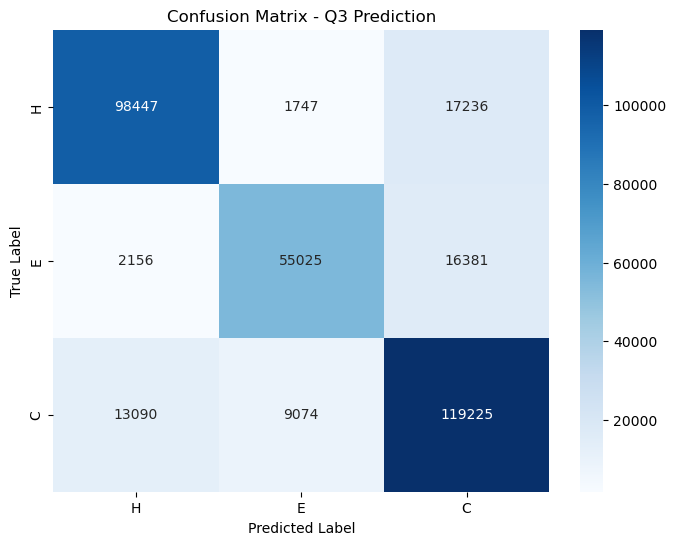


✓ Confusion matrix saved to 'esm_confusion_matrix.png'
H (Helix): 0.8383 (83.83%)
E (Sheet): 0.7480 (74.80%)
C (Coil): 0.8432 (84.32%)
Q3 (Avg Per-Class): 0.8099 (80.99%)

=== Summary ===
Best Val Acc:  0.8174 (81.74%)
Test Acc:      0.8204 (82.04%)
Difference:    0.0030

✓ Predictions saved to 'esm_test_predictions.csv'


In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

@torch.no_grad()
def test_model(model, dataloader, criterion, device, pad_idx):
    """
    Evaluates the model on a test set.
    This is identical to validate_epoch, but we define it
    here to match the function call in your cell.
    """
    model.eval()
    total_loss = 0
    total_correct = 0
    total_res_count = 0

    for X, Y, L in tqdm(dataloader, desc="Testing"):

        X = X.to(device, non_blocking=True).float() # Cast input to float32
        # ------------------------
        
        Y = Y.to(device, non_blocking=True)

        logits = model(X, L)
        
        T_b = logits.size(1)
        Y_trim = Y[:, :T_b]
        
        loss = criterion(logits.reshape(-1, logits.size(-1)), Y_trim.reshape(-1))

        total_loss += loss.item() * len(X)
        
        # Calculate accuracy
        preds = logits.argmax(dim=-1)
        
        # Create a mask to exclude padding indices
        mask = (Y_trim != pad_idx)
        
        total_correct += (preds[mask] == Y_trim[mask]).sum().item()
        total_res_count += mask.sum().item()

    avg_loss = total_loss / len(dataloader.dataset)
    avg_acc = total_correct / total_res_count if total_res_count > 0 else 0
    
    return avg_loss, avg_acc

@torch.no_grad()
def get_predictions_and_labels(model, dataloader, device, pad_idx):
    """Collect all predictions and true labels (excluding padding)."""
    all_preds = []
    all_labels = []
    
    model.eval()
    for X, Y, L in tqdm(dataloader, desc="Getting Predictions"):
        # --- FIX APPLIED HERE ---
        X = X.to(device, non_blocking=True).float() # Cast input to float32
        # ------------------------
        
        Y = Y.to(device, non_blocking=True)
        # L = L.to(device, non_blocking=True) # Not needed if model(X,L) handles L on CPU
        
        logits = model(X, L)
        preds = logits.argmax(dim=-1)  # [B, T]
        
        # Extract non-padded positions
        T_b = logits.size(1)
        Y_trim = Y[:, :T_b]
        mask = (Y_trim != pad_idx)
        
        all_preds.extend(preds[mask].cpu().numpy())
        all_labels.extend(Y_trim[mask].cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

print("\n=== Evaluating on Test Set ===")

# Load best model (if needed)
# Ensure the model is in float32, not .half()
checkpoint = torch.load('best_esm_q3_model.pt')
model_q3.load_state_dict(checkpoint['model_state_dict'])
model_q3.eval()

# Test evaluation
test_loss, test_acc = test_model(
    model_q3, test_loader_esm_q3, loss_fn_q3, DEVICE, Q3_PAD_INDEX
)

print(f"\n=== Test Results ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Detailed per-class metrics
test_preds, test_labels = get_predictions_and_labels(
    model_q3, test_loader_esm_q3, DEVICE, Q3_PAD_INDEX
)

# Classification report
target_names = ['H (Helix)', 'E (Sheet)', 'C (Coil)']
print("\n=== Classification Report ===")
print(classification_report(
    test_labels, test_preds, 
    target_names=target_names, 
    digits=4
))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print("\n=== Confusion Matrix ===")
print("         Predicted")
print("         H    E    C")
for i, label in enumerate(['H', 'E', 'C']):
    print(f"True {label}  {cm[i, 0]:5d} {cm[i, 1]:5d} {cm[i, 2]:5d}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['H', 'E', 'C'],
            yticklabels=['H', 'E', 'C'])
plt.title('Confusion Matrix - Q3 Prediction')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('esm_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrix saved to 'esm_confusion_matrix.png'")

# Per-class accuracy
class_acc_sum = 0
for i, name in enumerate(target_names):
    class_acc = cm[i, i] / cm[i, :].sum()
    class_acc_sum += class_acc
    print(f"{name}: {class_acc:.4f} ({class_acc*100:.2f}%)")

print(f"Q3 (Avg Per-Class): {class_acc_sum / 3.0:.4f} ({(class_acc_sum / 3.0)*100:.2f}%)")

# Compare with validation results
print(f"\n=== Summary ===")
print(f"Best Val Acc:  {checkpoint['val_acc']:.4f} ({checkpoint['val_acc']*100:.2f}%)")
print(f"Test Acc:      {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Difference:    {abs(test_acc - checkpoint['val_acc']):.4f}")

# Save predictions for further analysis
results_df = pd.DataFrame({
    'true_label': test_labels,
    'predicted_label': test_preds,
    'correct': test_labels == test_preds
})
results_df.to_csv('esm_test_predictions.csv', index=False)
print("\n✓ Predictions saved to 'esm_test_predictions.csv'")

## Initialize Q8 Model & Clean Up GPU

This block prepares for Q8 training.
* **Cell 13.1 (`18fa77e0`)**: Initializes a new `ESMProteinStructurePredictor` (`model_q8`) with `num_classes=Q8_NUM_CLASSES` .
* **Cell 13.2 (`137fd4c7`)**: This is a **crucial cleanup step**. It explicitly deletes the Q3 model (`del model_q3`), optimizer, and other variables from memory, then calls `gc.collect()` and `torch.cuda.empty_cache()` to free up GPU VRAM before starting the next training run.

In [ ]:

model_q8 = ESMProteinStructurePredictor(
    input_dim=480,        # ESM2 t12_35M dimension
    hidden_dim=512,
    num_layers=2,
    num_classes=Q8_NUM_CLASSES, 
    dropout=0.3,
    bidirectional=True
).to(DEVICE)

print(f"✓ Q8 model initialized with {Q8_NUM_CLASSES} output classes.")
print(f"Total parameters: {sum(p.numel() for p in model_q8.parameters()):,}")

✓ Q8 model initialized with 8 output classes.
Total parameters: 10,757,640


In [ ]:

try:

    del model_q3
    del optimizer # This was the Q3 optimizer
    del loss_fn_q3
    del scheduler
    del checkpoint # from Q3 eval
    print("Deleted Q3 model and optimizer variables.")
except NameError:
    print("Q3 model variables not found, continuing...")

# Collect garbage to free up Python's references
import gc
gc.collect()

# Empty the CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("✓ Cleared CUDA cache.")

Q3 model variables not found, continuing...
✓ Cleared CUDA cache.


In [ ]:
import torch

print("--- Inspecting Training Batch (v2) ---")

# Get one batch from your loader
batch = next(iter(train_loader_esm_q8))

print(f"Batch type: {type(batch)}")
print(f"Batch length: {len(batch)}") # Should be 2 (inputs, labels)

try:
    labels = batch[1] 
    print(f"\nSuccessfully got labels from batch[1]")
    print(f"Labels tensor shape: {labels.shape}")
except Exception as e:
    print(f"\nFailed to get labels from batch[1]: {e}")
    print("Please inspect the batch contents and adjust the index (e.g., batch[0]).")

    raise e

Q8_PAD_INDEX = -100 
n_classes = 8       

# --- Analysis ---
unique_labels = torch.unique(labels)
print(f"\n--- Analysis ---")
print(f"Unique labels found in batch: {unique_labels}")
print(f"Your Q8_PAD_INDEX is set to: {Q8_PAD_INDEX}")
print(f"Your n_classes is set to: {n_classes} (valid indices are [0, {n_classes-1}])")

# Find problematic labels
is_not_padding = (labels != Q8_PAD_INDEX)
is_out_of_range = (labels < 0) | (labels >= n_classes)

# Problematic labels are those that are BOTH not padding AND out of range
invalid_labels_mask = is_not_padding & is_out_of_range
invalid_labels = labels[invalid_labels_mask]

if invalid_labels.numel() > 0:
    print("\n--- !!! PROBLEM FOUND !!! ---")
    print(f"Found {invalid_labels.numel()} labels that are NOT the pad index ({Q8_PAD_INDEX})")
    print(f"but ARE outside the valid class range [0, {n_classes-1}].")
    print(f"Problematic values found: {torch.unique(invalid_labels)}")
    print("\nSOLUTION: Fix your data preprocessing script. All non-padding labels")
    print(f"MUST be integers between 0 and {n_classes-1}.")
else:
    print("\n--- ✓ This batch looks good ---")
    print("All labels are either the pad index or within the valid class range.")

--- Inspecting Training Batch (v2) ---
Batch type: <class 'list'>
Batch length: 3

Successfully got labels from batch[1]
Labels tensor shape: torch.Size([32, 1632])

--- Analysis ---
Unique labels found in batch: tensor([-100,    0,    1,    2,    3,    5,    6,    7])
Your Q8_PAD_INDEX is set to: -100
Your n_classes is set to: 8 (valid indices are [0, 7])

--- ✓ This batch looks good ---
All labels are either the pad index or within the valid class range.


## Train ESM-BiLSTM Model (Q8)

This cell trains the final **Q8 model** (`model_q8`).
* It uses the `train_loader_esm_q8` and `val_loader_esm_q8`.
* The `loss_fn_q8` is set to ignore `Q8_PAD_INDEX` (-100).
* The training loop saves the best-performing model (`best_esm_q8_model.pt`) based on the lowest validation loss.
* Finally, it plots the Q8 training history.

c:\Users\rombo\anaconda3\envs\neuralnet\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Q8 Training Configuration ===
Epochs: 30
Learning rate: 0.0001
Device: cuda
AMP enabled: False

=== Starting Q8 Training ===


Epoch  1/30 | Train Loss: 1.0643 | Val Loss: 0.9079 | Val Acc: 0.6741 | LR: 0.000100 | Time: 58.1s


Epoch  2/30 | Train Loss: 0.8892 | Val Loss: 0.8774 | Val Acc: 0.6831 | LR: 0.000100 | Time: 57.2s


Epoch  3/30 | Train Loss: 0.8633 | Val Loss: 0.8670 | Val Acc: 0.6863 | LR: 0.000100 | Time: 57.2s


Epoch  4/30 | Train Loss: 0.8452 | Val Loss: 0.8525 | Val Acc: 0.6915 | LR: 0.000100 | Time: 57.0s


Epoch  5/30 | Train Loss: 0.8308 | Val Loss: 0.8431 | Val Acc: 0.6954 | LR: 0.000100 | Time: 58.1s


Epoch  6/30 | Train Loss: 0.8186 | Val Loss: 0.8348 | Val Acc: 0.6989 | LR: 0.000100 | Time: 60.3s


Epoch  7/30 | Train Loss: 0.8078 | Val Loss: 0.8305 | Val Acc: 0.7000 | LR: 0.000100 | Time: 60.7s


Epoch  8/30 | Train Loss: 0.7972 | Val Loss: 0.8281 | Val Acc: 0.7008 | LR: 0.000100 | Time: 60.1s


Epoch  9/30 | Train Loss: 0.7851 | Val Loss: 0.8268 | Val Acc: 0.7034 | LR: 0.000100 | Time: 58.5s


Epoch 10/30 | Train Loss: 0.7725 | Val Loss: 0.8250 | Val Acc: 0.7030 | LR: 0.000100 | Time: 57.6s


Epoch 11/30 | Train Loss: 0.7606 | Val Loss: 0.8304 | Val Acc: 0.7021 | LR: 0.000100 | Time: 58.2s


Epoch 12/30 | Train Loss: 0.7457 | Val Loss: 0.8311 | Val Acc: 0.7041 | LR: 0.000100 | Time: 57.6s


Epoch 13/30 | Train Loss: 0.7318 | Val Loss: 0.8324 | Val Acc: 0.7038 | LR: 0.000100 | Time: 59.1s


Epoch 14/30 | Train Loss: 0.7133 | Val Loss: 0.8431 | Val Acc: 0.7034 | LR: 0.000050 | Time: 58.3s


Epoch 15/30 | Train Loss: 0.6859 | Val Loss: 0.8543 | Val Acc: 0.7007 | LR: 0.000050 | Time: 57.9s

Early stopping at epoch 15

=== Q8 Training Complete ===
Best validation loss: 0.8250 at epoch 10
Best validation accuracy: 0.7030

✓ Best Q8 model saved to 'best_esm_q8_model.pt'


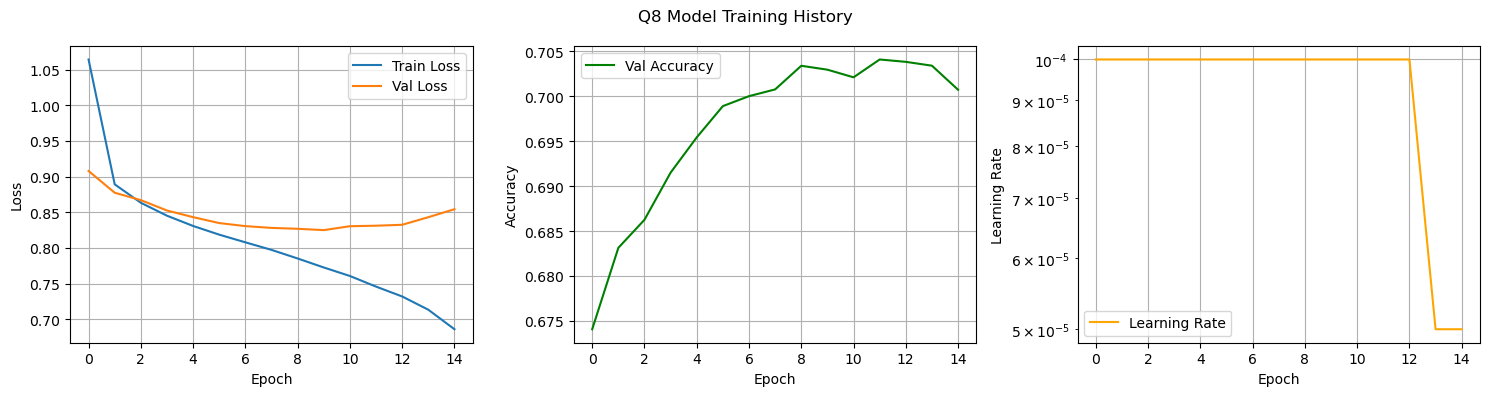


✓ Q8 Training plots saved to 'esm_training_history_q8.png'


In [ ]:
NUM_EPOCHS = 30
# We found 0.0001 worked for Q3, let's start there
LEARNING_RATE = 0.0001 
PATIENCE = 5

# --- Q8 Loss function (ignore Q8_PAD_INDEX) ---
loss_fn_q8 = nn.CrossEntropyLoss(ignore_index=Q8_PAD_INDEX) # <-- Q8 PAD

# --- Q8 Optimizer ---
optimizer_q8 = optim.Adam(model_q8.parameters(), lr=LEARNING_RATE)

# --- Q8 Learning rate scheduler ---
scheduler_q8 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_q8, mode='min', factor=0.5, patience=3, verbose=True
)

# --- Q8 Early stopping ---
early_stopper_q8 = EarlyStopper(patience=PATIENCE, min_delta=0.001)

scaler = GradScaler(enabled=False) 

print(f"\n=== Q8 Training Configuration ===")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Device: {DEVICE}")
print(f"AMP enabled: {scaler.is_enabled()}")

# --- Training history ---
history_q8 = {
    'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []
}

print("\n=== Starting Q8 Training ===")
best_val_loss_q8 = float('inf')
best_model_state_q8 = None

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()
    
    # --- Train ---
    train_loss = train_epoch(
        model_q8, 
        train_loader_esm_q8,  # <-- Q8 loader
        loss_fn_q8,           # <-- Q8 loss
        optimizer_q8,         # <-- Q8 optimizer
        DEVICE, 
        scaler, 
        Q8_PAD_INDEX          # <-- Q8 PAD
    )
    
    # --- Validate ---
    val_loss, val_acc = validate_epoch(
        model_q8, 
        val_loader_esm_q8,    # <-- Q8 loader
        loss_fn_q8,           # <-- Q8 loss
        DEVICE, 
        Q8_PAD_INDEX          # <-- Q8 PAD
    )
    
    scheduler_q8.step(val_loss)
    
    # --- Save best model ---
    if val_loss < best_val_loss_q8:
        best_val_loss_q8 = val_loss
        best_model_state_q8 = {
            'epoch': epoch,
            'model_state_dict': model_q8.state_dict(),
            'optimizer_state_dict': optimizer_q8.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc
        }
    
    current_lr = optimizer_q8.param_groups[0]['lr']
    history_q8['train_loss'].append(train_loss)
    history_q8['val_loss'].append(val_loss)
    history_q8['val_acc'].append(val_acc)
    history_q8['lr'].append(current_lr)
    
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch {epoch:2d}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | "
          f"LR: {current_lr:.6f} | "
          f"Time: {epoch_time:.1f}s")
    
    if early_stopper_q8.early_stop(val_loss):
        print(f"\nEarly stopping at epoch {epoch}")
        break

print("\n=== Q8 Training Complete ===")
if best_model_state_q8:
    print(f"Best validation loss: {best_val_loss_q8:.4f} at epoch {best_model_state_q8['epoch']}")
    print(f"Best validation accuracy: {best_model_state_q8['val_acc']:.4f}")

    # Load best model
    model_q8.load_state_dict(best_model_state_q8['model_state_dict'])

    # Save model
    torch.save(best_model_state_q8, 'best_esm_q8_model.pt') # <-- Q8 save path
    print("\n✓ Best Q8 model saved to 'best_esm_q8_model.pt'")
else:
    print("Training did not complete or no best model was saved.")

# --- Plot training history ---
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Q8 Model Training History")

ax1.plot(history_q8['train_loss'], label='Train Loss')
ax1.plot(history_q8['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

ax2.plot(history_q8['val_acc'], label='Val Accuracy', color='green')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.legend(); ax2.grid(True)

ax3.plot(history_q8['lr'], label='Learning Rate', color='orange')
ax3.set_xlabel('Epoch'); ax3.set_ylabel('Learning Rate'); ax3.set_yscale('log'); ax3.legend(); ax3.grid(True)

plt.tight_layout()
plt.savefig('esm_training_history_q8.png', dpi=150) # <-- Q8 plot
plt.show()
print("\n✓ Q8 Training plots saved to 'esm_training_history_q8.png'")

## Evaluate ESM-BiLSTM Model (Q8)

This cell evaluates the best Q8 model (`best_esm_q8_model.pt`) on the **test set** (`test_loader_esm_q8`).
1.  **Test Accuracy**: Calculates and prints the final test loss and accuracy for Q8.
2.  **Classification Report**: Prints a detailed report for all 8 classes.
3.  **Confusion Matrix**: Plots the 8x8 confusion matrix.
4.  **Save Results**: Saves the Q8 predictions to `esm_test_predictions_q8.csv`.

C:\Users\rombo\AppData\Local\Temp\ipykernel_25704\3309465286.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_q8 = torch.load('best_esm_q8_model.pt')



=== Evaluating Q8 Model on Test Set ===
Running test set evaluation...



=== Q8 Test Results ===
Test Loss: 0.8431
Test Accuracy: 0.7045 (70.45%)



=== Q8 Classification Report ===
              precision    recall  f1-score   support

   H (Helix)     0.8226    0.8929    0.8563    104784
   E (Sheet)     0.7727    0.8252    0.7981     69979
    C (Coil)     0.6132    0.6931    0.6507     79897
  B (Bridge)     0.5504    0.0533    0.0972      3583
I (Pi-Helix)     0.0000    0.0000    0.0000        30
    T (Turn)     0.5500    0.4941    0.5205     35673
 G (3-Helix)     0.3874    0.2478    0.3022     12616
    S (Bend)     0.4988    0.2537    0.3364     25819

    accuracy                         0.7045    332381
   macro avg     0.5244    0.4325    0.4452    332381
weighted avg     0.6878    0.7045    0.6889    332381


=== Q8 Confusion Matrix ===


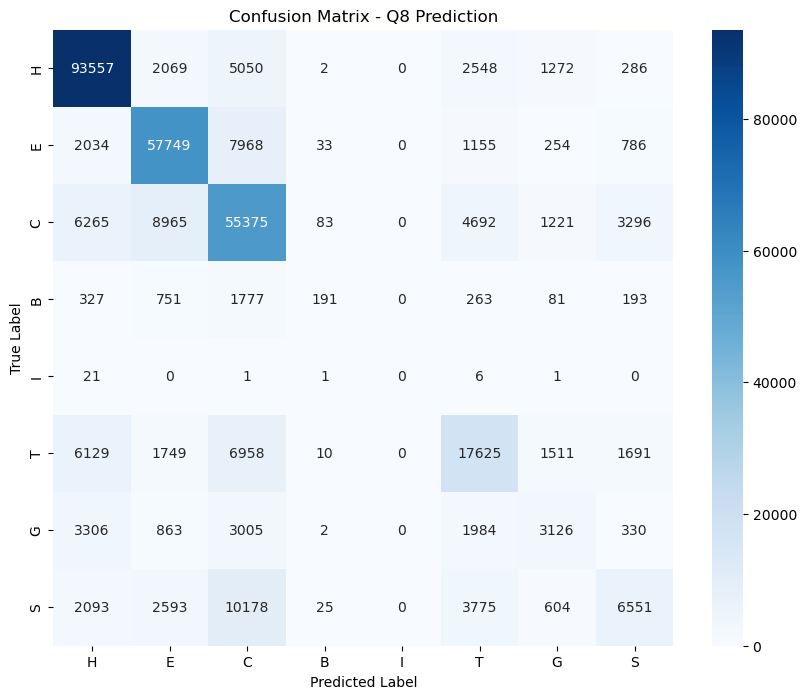


✓ Q8 Confusion matrix saved to 'esm_confusion_matrix_q8.png'

=== Q8 Summary ===
Best Val Acc:  0.7030 (70.30%)
Test Acc:      0.7045 (70.45%)
Difference:    0.0016

✓ Q8 Predictions saved to 'esm_test_predictions_q8.csv'


In [ ]:

print("\n=== Evaluating Q8 Model on Test Set ===")

try:
    # --- Load best Q8 model ---
    checkpoint_q8 = torch.load('best_esm_q8_model.pt')
    model_q8.load_state_dict(checkpoint_q8['model_state_dict'])
    model_q8.eval()

    # --- Test evaluation ---
    test_loss_q8, test_acc_q8 = test_model(
        model_q8, 
        test_loader_esm_q8,  # <-- Q8 loader
        loss_fn_q8,          # <-- Q8 loss
        DEVICE, 
        Q8_PAD_INDEX         # <-- Q8 PAD
    )

    print(f"\n=== Q8 Test Results ===")
    print(f"Test Loss: {test_loss_q8:.4f}")
    print(f"Test Accuracy: {test_acc_q8:.4f} ({test_acc_q8*100:.2f}%)")

    # --- Detailed per-class metrics ---
    from sklearn.metrics import classification_report, confusion_matrix
    import numpy as np
    @torch.no_grad()
    def get_predictions_and_labels(model, dataloader, device, pad_idx):
        """Collect all predictions and true labels (excluding padding)."""
        all_preds = []
        all_labels = []
        model.eval()
        pbar = tqdm(dataloader, desc="Getting Predictions", leave=False)
        for X, Y, L in pbar:
            X = X.to(device, non_blocking=True).float() # <-- FIX: .float()
            Y = Y.to(device, non_blocking=True)
            
            with torch.autocast(device_type=device.type, enabled=True):
                logits = model(X, L)
                
            preds = logits.argmax(dim=-1)  # [B, T]
            
            T_b = logits.size(1)
            Y_trim = Y[:, :T_b]
            mask = (Y_trim != pad_idx)
            
            all_preds.append(preds[mask].cpu().numpy())
            all_labels.append(Y_trim[mask].cpu().numpy())
        
        return np.concatenate(all_preds), np.concatenate(all_labels)

    # --- Get predictions ---
    test_preds_q8, test_labels_q8 = get_predictions_and_labels(
        model_q8, 
        test_loader_esm_q8, # <-- Q8 loader
        DEVICE, 
        Q8_PAD_INDEX        # <-- Q8 PAD
    )

    # --- Q8 Classification report ---
    # Q8_ALPHABET = list("HECBITGS")
    target_names_q8 = [
        'H (Helix)', 'E (Sheet)', 'C (Coil)', 
        'B (Bridge)', 'I (Pi-Helix)', 'T (Turn)', 
        'G (3-Helix)', 'S (Bend)'
    ]
    
    print("\n=== Q8 Classification Report ===")
    print(classification_report(
        test_labels_q8, 
        test_preds_q8, 
        target_names=target_names_q8, 
        digits=4,
        zero_division=0
    ))

    # --- Q8 Confusion matrix ---
    cm_q8 = confusion_matrix(test_labels_q8, test_preds_q8)
    print("\n=== Q8 Confusion Matrix ===")
    
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_q8, annot=True, fmt='d', cmap='Blues',
                xticklabels=list("HECBITGS"),
                yticklabels=list("HECBITGS"))
    plt.title('Confusion Matrix - Q8 Prediction')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('esm_confusion_matrix_q8.png', dpi=150, bbox_inches='tight') # <-- Q8 path
    plt.show()
    print("\n✓ Q8 Confusion matrix saved to 'esm_confusion_matrix_q8.png'")

    print(f"\n=== Q8 Summary ===")
    print(f"Best Val Acc:  {checkpoint_q8['val_acc']:.4f} ({checkpoint_q8['val_acc']*100:.2f}%)")
    print(f"Test Acc:      {test_acc_q8:.4f} ({test_acc_q8*100:.2f}%)")
    print(f"Difference:    {abs(test_acc_q8 - checkpoint_q8['val_acc']):.4f}")

    # --- Save predictions ---
    results_df_q8 = pd.DataFrame({
        'true_label': test_labels_q8,
        'predicted_label': test_preds_q8,
        'correct': test_labels_q8 == test_preds_q8
    })
    results_df_q8.to_csv('esm_test_predictions_q8.csv', index=False) # <-- Q8 path
    print("\n✓ Q8 Predictions saved to 'esm_test_predictions_q8.csv'")

except FileNotFoundError:
    print("\nERROR: 'best_esm_q8_model.pt' not found.")
    print("Please run the Q8 training cell first.")
except Exception as e:
    print(f"\nAn error occurred during evaluation: {e}")